In [2]:
import tensorflow as tf
from tensorflow import keras

# 准备数据

In [3]:
def load_image(img_path, size=(32, 32)):
    label = tf.constant(1, tf.int8) if tf.strings.regex_full_match(img_path, ".*automobile.*") else tf.constant(0, tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size) / 255.0
    return img, label
    

In [4]:
BATCH_SIZE = 100
train_ds = tf.data.Dataset.list_files('/home/kdd/python/eat_tensorflow2_in_30_days/data/cifar2/train/*/*.jpg') \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.list_files('/home/kdd/python/eat_tensorflow2_in_30_days/data/cifar2/test/*/*.jpg') \
          .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
          .batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

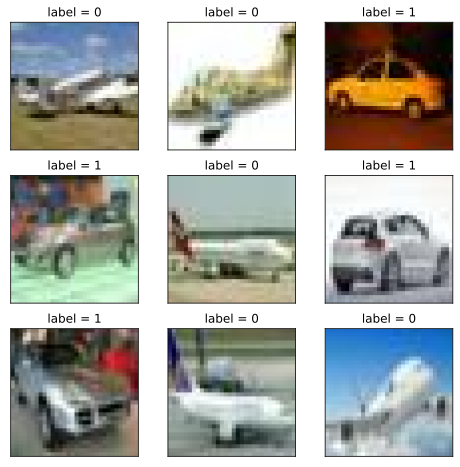

In [25]:
from matplotlib import pyplot as plt

'''
dataset.unbatch():  Splits elements of a dataset into multiple elements
'''
plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(train_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title('label = %d'%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [7]:
for x, y in train_ds.take(1):
    print(x.shape, y.shape)

(100, 32, 32, 3) (100,)


# 模型搭建与训练

In [34]:
tf.keras.backend.clear_session()

inputs = keras.layers.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, kernel_size=(3,3))(inputs)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(64, kernel_size=(5, 5))(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [35]:
import datetime
import os
from pathlib import Path

stamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = str(Path('../logs/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy']
             )
history = model.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=[tensorboard_callback], workers=4)

Train for 100 steps, validate for 20 steps
Epoch 1/20
100/100 [==============================] - 4s 45ms/step - loss: 0.4430 - accuracy: 0.7867 - val_loss: 0.3208 - val_accuracy: 0.8625
Epoch 2/20
100/100 [==============================] - 4s 40ms/step - loss: 0.3371 - accuracy: 0.8554 - val_loss: 0.2788 - val_accuracy: 0.8770
Epoch 3/20
100/100 [==============================] - 4s 39ms/step - loss: 0.2930 - accuracy: 0.8756 - val_loss: 0.2325 - val_accuracy: 0.9070
Epoch 4/20
100/100 [==============================] - 4s 41ms/step - loss: 0.2452 - accuracy: 0.8977 - val_loss: 0.2304 - val_accuracy: 0.9030
Epoch 5/20
100/100 [==============================] - 4s 40ms/step - loss: 0.2046 - accuracy: 0.9200 - val_loss: 0.1862 - val_accuracy: 0.9240
Epoch 6/20
100/100 [==============================] - 4s 39ms/step - loss: 0.1817 - accuracy: 0.9269 - val_loss: 0.1740 - val_accuracy: 0.9350
Epoch 7/20
100/100 [==============================] - 4s 38ms/step - loss: 0.1579 - accuracy: 0.938

# 评估模型

In [10]:
%load_ext tensorboard

In [36]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ../logs/keras_model (started 1:14:54 ago; pid 29318)
  - port 6007: logdir ../logs/20200617-141242/ (started 1:12:20 ago; pid 29450)


In [13]:
notebook.start('--logdir ../logs/20200617-141242/')

In [14]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history.index = range(1, len(df_history) + 1)
df_history.index.name='epoch'

In [15]:
def plot_metric(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history['val_'+metric]
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'bo--')
    plt.plot(epochs, val_metric, 'ro--')
    plt.title('Train and Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()

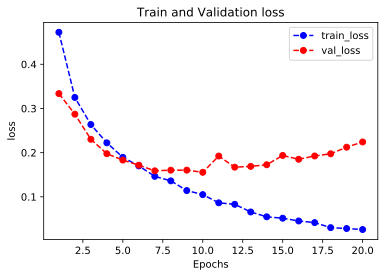

In [16]:
plot_metric(history, 'loss')

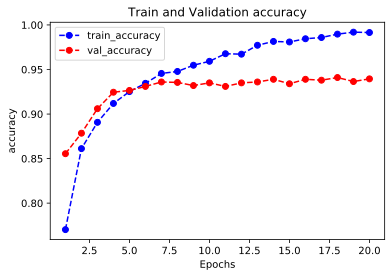

In [17]:
plot_metric(history, 'accuracy')

In [18]:
val_loss, val_acc = model.evaluate(test_ds, workers=4)

20/20 [==============================] - 0s 14ms/step - loss: 0.2242 - accuracy: 0.9395


# 预测

In [19]:
model.predict(test_ds)

array([[9.9958295e-01],
       [8.4203158e-08],
       [8.3306378e-01],
       ...,
       [9.9962413e-01],
       [2.6165853e-07],
       [1.0000000e+00]], dtype=float32)

In [20]:
# 使用model.predict_on_batch对一个批量进行预测
for x, y in test_ds.take(1):
    print(model.predict_on_batch(x[:20]))

tf.Tensor(
[[9.9997389e-01]
 [9.9999917e-01]
 [8.2333905e-08]
 [9.9976224e-01]
 [9.9999988e-01]
 [9.9996281e-01]
 [5.4218242e-07]
 [9.9942017e-01]
 [6.0053655e-09]
 [3.7609609e-06]
 [9.9999988e-01]
 [1.9177018e-03]
 [1.0511260e-03]
 [2.1842353e-03]
 [1.3804132e-03]
 [9.6618706e-01]
 [1.5672028e-07]
 [9.9999833e-01]
 [5.1986215e-05]
 [9.9994743e-01]], shape=(20, 1), dtype=float32)


# 保存模型

In [21]:
# 仅保存权重张量
model.save_weights('../logs/tf_model_weights.ckpt', save_format='tf')

In [23]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署
model.save('../logs/tf_savedmodel', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../logs/tf_savedmodel/assets


In [24]:
model_load = tf.keras.models.load_model('../logs/tf_savedmodel/')
model_load.evaluate(test_ds)

20/20 [==============================] - 0s 18ms/step - loss: 0.2241 - accuracy: 0.9395


[0.22407420426607133, 0.9395]

In [26]:
elements = [ [1, 2, 3], [1, 2], [1, 2, 3, 4] ]
dataset = tf.data.Dataset.from_generator(lambda: elements, tf.int64)

In [28]:
for item in dataset:
    print(item)

tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([1 2], shape=(2,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)


In [29]:
ds = dataset.unbatch()

In [30]:
ds

<_UnbatchDataset shapes: <unknown>, types: tf.int64>

In [31]:
for i in ds:
    print(i)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
